# Inference

In this notebook I've experimented an approach to do online retraining of a simple lightgbm model.

- EDA: https://www.kaggle.com/code/simonedegasperis/starter-eda
- train: https://www.kaggle.com/code/simonedegasperis/lgbm-model-training

Kudos to https://www.kaggle.com/code/motono0223/js24-preprocessing-create-lags for historical data with added lags feature that I've used to train the initial version of the model.

For retraining I've sampled from each date of historical data a random 1% of the data and I've added online data. I tried to retrain the model each N days by gradually increasing the cache which was defined as global variable and I've then averaged the solution of the initial model and the new retrained model.

The purpose of choosing a small fraction of data for retraining was to try to stay within 10 minutes limit between 2 consecutive batches.
I hope you will find the solution helpfull to build a better model.

In the following I present a schematic view of the idea

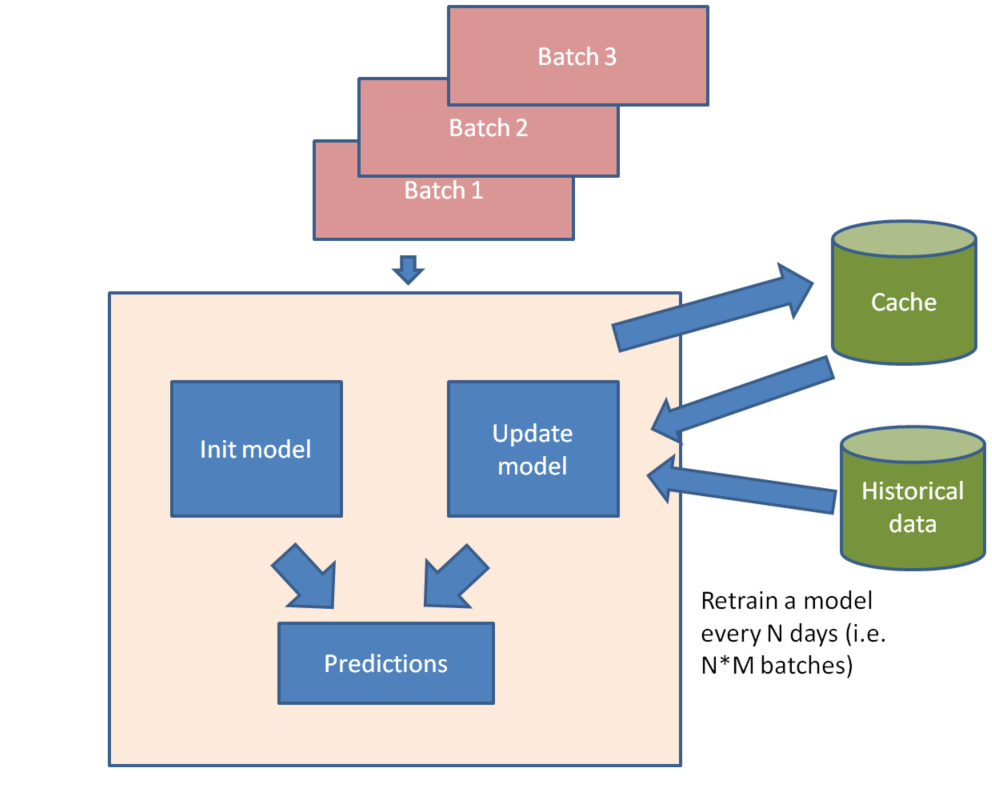

Note: While this current implentation does not improve the score of the single model, it may be a good starting point to implement some startegies based on online re-training.

# Changelog

**v12**: Empty cache list after cache update

**v11**: fix reset day count after each retrain, store only last 2 lags and update cache only when retraining to reduce processing time

# Libraries

In [2]:
# imports
import os
import glob
import numpy as np
import pandas as pd
import polars as pl
import lightgbm as lgb
import xgboost as xgb
import pickle
import kaggle_evaluation.jane_street_inference_server

ModuleNotFoundError: No module named 'kaggle_evaluation'

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
from pytorch_lightning import (LightningDataModule, LightningModule, Trainer)
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Timer

# Configs

In [1]:
class CONFIG:
    seed = 42
    METHOD_LIST = ['lightgbm', 'xgboost', 'catboost']
    target_col = "responder_6"
    all_cols = ["date_id", "symbol_id", "time_id", "weight"] + [f"feature_{idx:02d}" for idx in range(79)]+ [f"responder_{idx}_lag_1" for idx in range(9)] + [target_col]
    test_cols = ["row_id", "date_id", "symbol_id", "time_id"] + [f"feature_{idx:02d}" for idx in range(79)]+ [f"responder_{idx}_lag_1" for idx in range(9)] + [target_col]
    feature_cols = ["symbol_id", "time_id"] + [f"feature_{idx:02d}" for idx in range(79)]+ [f"responder_{idx}_lag_1" for idx in range(9)]
    only_features = ["row_id", "date_id", "symbol_id", "time_id"] + [f"feature_{idx:02d}" for idx in range(79)]
    only_lags = ["row_id", "date_id", "symbol_id", "time_id"] + [f"responder_{idx}_lag_1" for idx in range(9)] 
    data_paths = ["/kaggle/input/my-lgbm-model-jane/lgbm_model_0.json","/kaggle/input/js24-preprocessing-create-lags/training.parquet/"]
    retrain = True
    EVAL = False
    
    
    regression_lgb_params = {
        'objective': 'regression',
        'metric': 'rmse', 
        'learning_rate': 0.05,
        'num_leaves': 31,
        'seed': SEED,
    }
    regression_xgb_params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate': 0.05, 
        'max_depth': 7,
        'random_state': SEED,
    }
    
    regression_cat_params = {
        'loss_function': 'RMSE',
        'learning_rate': 0.05, 
        'iterations': num_boost_round, 
        'depth': 7, 
        'random_seed': SEED,
    }

# Read historical data

In [4]:
files = glob.glob(os.path.join(CONFIG.data_paths[1], "*/*parquet"))

In [5]:
files.sort()

In [6]:
pl_train = pl.concat([pl.read_parquet(_f, columns=CONFIG.all_cols).sample(fraction=0.01) for _f in files])

In [7]:
pl_train = pl_train.sort(["date_id", "time_id"])
pl_train = pl_train.with_row_count(name="row_id")
pl_train = pl_train.with_columns(pl.col("row_id").cast(pl.Int64))  # Ensure row_id is uint32


/tmp/ipykernel_17/3687664121.py:2: DeprecationWarning: `DataFrame.with_row_count` is deprecated. Use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  pl_train = pl_train.with_row_count(name="row_id")


# Load model

In [8]:
# load model
model_list_dict = {}
for method in CFG.METHOD_LIST:
    model_list_dict[method] = []
    for fold in range(CFG.N_SPLIT):
        model_list_dict[method].append(pickle.load(open(f'/kaggle/input/jsr-tmdf-gradient-boosting-models-training/models/{method}_fold{fold+1}_seed{CFG.SEED}_ver{CFG.VER}.pkl', 'rb')))

[LightGBM] [Warning] Ignoring unrecognized parameter 'early_stopping_min_delta' found in model string.


In [ ]:
def lightgbm_inference(model, x_test: pd.DataFrame):
    return model.predict(x_test)

def xgboost_inference(model, x_test: pd.DataFrame):
    return model.predict(xgb.DMatrix(x_test))

def catboost_inference(model, x_test: pd.DataFrame):
    return model.predict(x_test)

# Inference

In [11]:
# we use historical data with new data hold in a cache to retrain the model
pl_train.head()

row_id,date_id,symbol_id,time_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,…,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1,responder_6
i64,i16,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,1101,26,0,0.569278,0.083284,0.122174,0.276094,0.121147,2.51448,-0.763609,0.273775,0.18034,0.318395,26,12,158,-1.211221,-0.159639,-1.001016,null,0.365785,null,-1.067099,-1.590416,-0.335021,-0.321275,-1.232732,-0.46846,-0.483004,-0.071141,-1.089516,-1.938108,-0.488884,-0.484524,-0.290879,-0.226033,…,null,null,-1.092247,null,-1.867843,1.060125,null,-0.404494,-0.174403,0.659961,0.093509,0.685506,0.390018,null,null,-0.888281,-0.022221,-0.499902,-0.900528,-0.409345,-0.713647,null,null,8.328077,7.130904,8.747465,7.952577,null,null,null,null,null,null,null,null,null,0.172212
1,1101,30,4,0.961726,0.26596,0.928681,-0.520924,0.561101,2.806687,-1.002168,-0.760872,-0.131424,0.580508,81,2,534,-0.532117,3.660651,0.991002,null,-0.358197,-0.263153,-0.90085,-1.415493,0.245584,-0.177098,-0.669685,0.022534,-1.467446,-0.519498,-1.670954,-1.382747,0.775237,-0.240173,0.084743,-0.189435,…,null,null,1.666509,null,-1.252168,0.982038,null,-1.299301,-1.779762,0.659961,-0.25745,-0.150762,-0.188023,-0.954864,-0.921373,-0.22903,6.414062,1.467452,-1.006736,0.726393,-0.344484,null,null,-0.242248,-0.356881,-0.335153,-0.384693,null,null,null,null,null,null,null,null,null,0.823051
2,1101,27,5,1.546658,0.243486,0.474983,-0.219907,0.140995,2.291635,-0.574791,-0.304703,-0.094289,0.201207,82,3,539,-0.828031,0.88514,0.093096,null,-0.593745,-1.059727,-0.775546,-1.509316,0.754765,-0.109614,-0.124975,-0.590087,1.517069,1.864487,-1.799769,-0.386519,1.190632,-0.804052,-1.005783,-0.14702,…,null,null,0.365454,null,-1.701683,2.024842,null,0.13847,-0.233516,0.659961,-0.459373,-0.322481,-0.281889,-1.638846,-2.178132,-0.552764,1.090647,0.159071,-0.791876,0.530554,-0.085143,null,null,-0.285146,-0.206945,-0.232155,-0.337365,null,null,null,null,null,null,null,null,null,0.338349
3,1101,20,5,0.779391,-0.192324,0.918432,-0.583309,-0.238405,1.942621,-0.628514,-0.56815,-0.218155,0.310595,30,10,50,0.213531,11.933814,3.240441,null,-0.209954,-0.334605,-1.304775,-1.52707,-0.042794,-0.194391,-0.76134,-0.578332,-1.174788,-0.881458,0.785472,-0.818967,-1.148275,-0.636528,-0.494353,-0.213931,…,null,null,0.491805,null,-0.282221,2.618297,null,3.358555,1.470888,0.659961,-0.319073,-0.171626,-0.281422,-1.511299,-1.168491,0.116332,5.321181,1.998273,0.4184,15.445238,3.635695,null,null,0.035893,-0.012843,-0.038202,-0.094202,null,null,null,null,null,null,null,null,null,4.877335
4,1101,5,8,2.045885,-0.008003,0.973345,-0.15531,0.389989,2.090332,-0.934847,-0.595418,-0.474548,0.693876,2,10,171,-0.532781,1.787492,0.706746,null,-0.610671,-0.405023,-2.222233,-2.891187,-0.450201,-0.120343,0.429265,-0.009082,-1.191422,-0.486201,-1.217726,0.19128,1.835943,-0.439846,-0.581523,-0.162177,…,null,null,-1.126355,null,-1.686945,0.855373,null,-1.50686,-1.745841,0.659961,-0.479429,-0.282685,-0.271901,-1.337599,-1.986644,-0.212605,4.312428,1.989278,-0.886252,0.339916,0.168976,null,nu

In [12]:
# Initialize an empty DataFrame as the global cache
cache = None
cache_list = []
batch_count = 0
day_count = 0
new_lgbm_model = None
lags_ : pl.DataFrame | None = None
# Replace this function with your inference code.
# You can return either a Pandas or Polars dataframe, though Polars is recommended.
# Each batch of predictions (except the very first) must be returned within 1 minute of the batch features being provided.
def predict(test: pl.DataFrame, lags: pl.DataFrame | None) -> pl.DataFrame | pd.DataFrame:
    """Make a prediction."""
    # All the responders from the previous day are passed in at time_id == 0. We save them in a global variable for access at every time_id.
    # Use them as extra features, if you like.
    global cache          # Declare the global cache
    global batch_count
    global day_count
    global new_lgbm_model
    global lags_
    global cache_list

    # Store lags, since they are provided at the start of each day but no for other tiòe_id of the same day
    if lags is not None:
        lags_ = lags
        day_count += 1

    # Init prediction
    predictions = test.select(
        'row_id',
        pl.lit(0.0).alias('responder_6'),
    )

    if not lags_ is None:
        lags = lags_.group_by(["date_id", "symbol_id"], maintain_order=True).last() # pick up last record of previous date
        lags = lags.drop(["time_id"])
        test = test.join(lags, on=["date_id", "symbol_id"],  how="left")
    else:
        test = test.with_columns(
            ( pl.lit(0.0).alias(f'responder_{idx}_lag_1') for idx in range(9) )
        )

    if CONFIG.retrain:
        print(f"Filling cache for batch count {batch_count}")
        cache_list.append(test)

    # initialize preds
    preds = np.zeros((test.shape[0],))

    # lightgbm model
    X = test[CONFIG.feature_cols].to_numpy()
  
    # re-train a model on the fly every N days
    if CONFIG.retrain and day_count % 30 == 0 and day_count >= 30:
        print("Using cache data to retrain the model")
        
        # Update the cache
        if cache_list:
            cache_update = pl.concat(cache_list, rechunk=True)
            if cache is not None:
                cache = pl.concat([cache, cache_update], rechunk=True)
            else:
                cache = cache_update
            cache_list.clear()
        else:
            print("Warning: cache_list is empty. Skipping cache update.")

        # Prepare the training data
        labels = cache[['date_id', 'symbol_id', 'responder_6_lag_1']]
        labels = labels.group_by(["date_id", "symbol_id"], maintain_order=True).last()
        lag_cols_rename = {"responder_6_lag_1": "responder_6"}
        labels = labels.rename(lag_cols_rename)
        labels = labels.with_columns(
            date_id=pl.col('date_id') - 1  # Shift labels by 1 day
        )
        train = cache.group_by(["date_id", "symbol_id"], maintain_order=True).last()
        train = train.join(labels, on=["date_id", "symbol_id"], how="left")
        train = train.drop(["is_scored", "weight"])

        hist_data = pl_train.select(train.columns)
        train = train.select([pl.col(col).cast(hist_data.schema[col]) for col in hist_data.columns])
        train = pl.concat([hist_data, train], rechunk=True)

        X_train = train[CONFIG.feature_cols].to_numpy()
        y_train = train.select(CONFIG.target_col).to_numpy().flatten()

        # Retrain each model type
        for method in CONFIG.METHOD_LIST:
            print(f"Retraining {method} model...")
            if method == 'lightgbm':
                train_data = lgb.Dataset(X_train, label=y_train)
                new_lgbm_model = lgb.train(
                    CONFIG.lgb_params,  # Replace with your LightGBM parameters
                    train_data,
                    num_boost_round=CONFIG.num_boost_round
                )
                #model_list_dict[method][0] = new_lgbm_model  # Update the model in the dictionary
            elif method == 'xgboost':
                # Add retraining logic for XGBoost if needed
                pass
            elif method == 'catboost':
                # Add retraining logic for CatBoost if needed
                pass

        # Reset counters
        day_count = 0

    # average original model with new retrained model
    if new_lgbm_model:
        # lightgbm models
        y_pred1 = new_lgbm_model.predict(X, num_iteration=new_lgbm_model.best_iteration)
        y_pred2 = []
        for method in CONFIG.METHOD_LIST:
            for model in model_list_dict[method]:
                if method == 'lightgbm':
                    pred.append(lightgbm_inference(model, X))
                if method == 'xgboost':
                    pred.append(xgboost_inference(model, X))
                if method == 'catboost':
                    pred.append(catboost_inference(model, X))
                    
            y_pred2 = np.mean(pred, axis=0)
            
        y_pred = (y_pred1+y_pred2)/2
    else:
        # lightgbm model
        # y_pred = lgbm_model.predict(X, num_iteration=lgbm_model.best_iteration)
        pred = []
        for method in CONFIG.METHOD_LIST:
            for model in model_list_dict[method]:
                if method == 'lightgbm':
                    pred.append(lightgbm_inference(model, X))
                if method == 'xgboost':
                    pred.append(xgboost_inference(model, X))
                if method == 'catboost':
                    pred.append(catboost_inference(model, X))
                    
            y_pred = np.mean(pred, axis=0)

    preds = y_pred
    print(f"predict> preds.shape =", preds.shape)
    
    predictions = \
    test.select('row_id').\
    with_columns(
        pl.Series(
            name   = 'responder_6', 
            values = np.clip(preds, a_min = -5, a_max = 5),
            dtype  = pl.Float64,
        )
    )

    if isinstance(predictions, pl.DataFrame):
        assert predictions.columns == ['row_id', 'responder_6']
    elif isinstance(predictions, pd.DataFrame):
        assert (predictions.columns == ['row_id', 'responder_6']).all()
    else:
        raise TypeError('The predict function must return a DataFrame')
    # Confirm has as many rows as the test data.
    assert len(predictions) == len(test)

    batch_count+=1

    return predictions

In [13]:
"""
test = pl.read_parquet('/kaggle/input/jane-street-real-time-market-data-forecasting/test.parquet')
lags = pl.read_parquet('/kaggle/input/jane-street-real-time-market-data-forecasting/lags.parquet')
# Initialize an empty DataFrame as the global cache
cache = pl.DataFrame()
batch_count = 0
day_count = 0
new_lgbm_model = None
hist_data = pl.DataFrame()
train = pl.DataFrame()
lags_ : pl.DataFrame | None = None
cache_list = []
predict(test, lags)
"""

"\ntest = pl.read_parquet('/kaggle/input/jane-street-real-time-market-data-forecasting/test.parquet')\nlags = pl.read_parquet('/kaggle/input/jane-street-real-time-market-data-forecasting/lags.parquet')\n# Initialize an empty DataFrame as the global cache\ncache = pl.DataFrame()\nbatch_count = 0\nday_count = 0\nnew_lgbm_model = None\nhist_data = pl.DataFrame()\ntrain = pl.DataFrame()\nlags_ : pl.DataFrame | None = None\ncache_list = []\npredict(test, lags)\n"

# Evaluation with API

In [14]:
if CONFIG.EVAL:
    test_dir = '/kaggle/input/janestreet-updated-simulator-for-time-series-api/debug/test.parquet'
    lags_dir = '/kaggle/input/janestreet-updated-simulator-for-time-series-api/debug/lags.parquet'
else:
    test_dir = '/kaggle/input/jane-street-real-time-market-data-forecasting/test.parquet'
    lags_dir = '/kaggle/input/jane-street-real-time-market-data-forecasting/lags.parquet'

In [15]:
inference_server = kaggle_evaluation.jane_street_inference_server.JSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '/kaggle/input/jane-street-real-time-market-data-forecasting/test.parquet',
            '/kaggle/input/jane-street-real-time-market-data-forecasting/lags.parquet',
        )
    )

Filling cache for batch count 0
predict> preds.shape = (39,)


In [16]:
def weighted_zero_mean_r2(y_true, y_pred, weights):
    """
    Calculate the sample weighted zero-mean R-squared score.

    Parameters:
    y_true (numpy.ndarray): Ground-truth values for responder_6.
    y_pred (numpy.ndarray): Predicted values for responder_6.
    weights (numpy.ndarray): Sample weight vector.

    Returns:
    float: The weighted zero-mean R-squared score.
    """
    numerator = np.sum(weights * (y_true - y_pred)**2)
    denominator = np.sum(weights * y_true**2)
    
    r2_score = 1 - numerator / denominator
    return r2_score

In [17]:
if CONFIG.EVAL:

    submission_file = pd.read_parquet('/kaggle/working/submission.parquet')
    y_pred = submission_file['responder_6']
    
    valid_df = pl.read_parquet("/kaggle/input/janestreet-updated-simulator-for-time-series-api/valid_df.parquet")
    
    y_true = valid_df.select("responder_6").to_numpy().reshape(-1)
    
    weights = valid_df.select("weight").to_numpy().reshape(-1)
    
    print(weighted_zero_mean_r2(y_true, y_pred, weights))